# Dependencies


In [3]:
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import BatchLoader
from spektral.datasets import TUDataset
from spektral.layers import GCSConv, GlobalSumPool, GraphMasking, MinCutPool

import networkx as nx
import numpy as np

import igraph as ig
import chart_studio.plotly
import plotly.graph_objs as go

# Config

In [2]:
learning_rate = 1e-3  # Learning rate
epochs = 10  # Number of training epochs
batch_size = 32  # Batch size

# Data


In [4]:
dataset = TUDataset("PROTEINS", clean=True)

# Parameters
N = max(g.n_nodes for g in dataset)
F = dataset.n_node_features  # Dimension of node features
S = dataset.n_edge_features  # Dimension of edge features
n_out = dataset.n_labels  # Dimension of the target

Successfully loaded PROTEINS.


In [11]:
dataset[3].

TypeError: getattr(): attribute name must be string

TypeError: getattr(): attribute name must be string

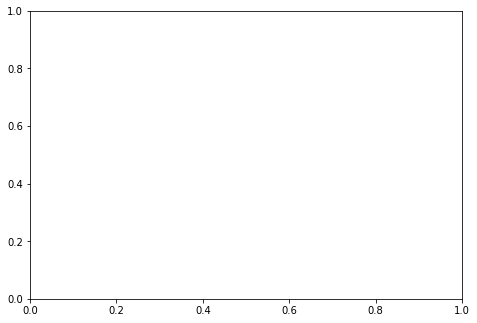

In [7]:
nx.draw(dataset[0])

In [17]:
# Train/test split
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]

loader_tr = BatchLoader(dataset_tr, batch_size=batch_size, mask=True)
loader_va = BatchLoader(dataset_va, batch_size=batch_size, mask=True)
loader_te = BatchLoader(dataset_te, batch_size=batch_size, mask=True)

# Model 

In [5]:
class Net(Model):
    def __init__(self):
        super(Net, self).__init__()
        self.mask = GraphMasking()
        self.conv1 = GCSConv(32, activation="relu")
        self.pool = MinCutPool(N // 2)
        self.conv2 = GCSConv(16, activation="relu")
        self.conv3 = GCSConv(8, activation="relu")
        self.global_pool = GlobalSumPool()
        self.dense1 = Dense(n_out)

    def call(self, inputs):
        x, a = inputs
        x = self.mask(x)
        x = self.conv1([x, a])
        x_pool, a_pool = self.pool([x, a])
        x_pool = self.conv2([x_pool, a_pool])
        output = self.global_pool(x_pool)
        output = self.dense1(output)

        return output


model = Net()
opt = Adam(lr=learning_rate)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["acc"])

c:\Users\suyash\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


# Training 


In [7]:
model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    epochs=epochs,
    validation_data=loader_va,
    validation_steps=loader_va.steps_per_epoch,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)],
)

Epoch 1/10
25/25 [==============================] - 20s 384ms/step - loss: 1.5929 - acc: 0.3474 - val_loss: 1.2289 - val_acc: 0.3608
Epoch 2/10
25/25 [==============================] - 9s 358ms/step - loss: 1.1540 - acc: 0.4449 - val_loss: 1.0898 - val_acc: 0.5979
Epoch 3/10
25/25 [==============================] - 8s 343ms/step - loss: 1.0596 - acc: 0.6551 - val_loss: 1.0734 - val_acc: 0.6289
Epoch 4/10
25/25 [==============================] - 8s 333ms/step - loss: 1.0448 - acc: 0.6538 - val_loss: 1.0382 - val_acc: 0.6495
Epoch 5/10
25/25 [==============================] - 9s 343ms/step - loss: 1.0343 - acc: 0.6526 - val_loss: 1.0335 - val_acc: 0.6392
Epoch 6/10
25/25 [==============================] - 9s 361ms/step - loss: 1.0275 - acc: 0.6526 - val_loss: 1.0028 - val_acc: 0.6701
Epoch 7/10
25/25 [==============================] - 8s 322ms/step - loss: 1.0216 - acc: 0.6526 - val_loss: 1.0169 - val_acc: 0.6495
Epoch 8/10
25/25 [==============================] - 8s 332ms/step - loss: 1

In [8]:
model.summary()

Model: "net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 graph_masking (GraphMasking  multiple                 0         
 )                                                               
                                                                 
 gcs_conv (GCSConv)          multiple                  288       
                                                                 
 min_cut_pool_1 (MinCutPool)  multiple                 10230     
                                                                 
 gcs_conv_2 (GCSConv)        multiple                  520       
                                                                 
 global_sum_pool (GlobalSumP  multiple                 0         
 ool)                                                            
                                                                 
 dense (Dense)               multiple                  18      

# Evalutaion


In [ ]:
print("Testing model")
loss, acc = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}. Test acc: {}".format(loss, acc))